In [1]:
#Wir importieren die benötigten Bibliotheken
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import place_poles, cont2discrete
import matplotlib as mpl
import matplotlib.pyplot as plt

#Einfacher struct-Datentyp a la C oder Matlab
class struct:
    pass;


In [2]:
params=struct()
params.g=9.81
params.l=0.4
params.m=0.2
params.M=2.0

# 1 Modell des Brückenkrans
## 1.1 Nichlineares Modell 
\begin{equation}\boldsymbol{x}=
\begin{pmatrix}
x_1\\x_2\\x_3\\x_4
\end{pmatrix}=\begin{pmatrix}
\theta\\\dot\theta\\D\\\dot{D}
\end{pmatrix}
\end{equation}
Zur Auswertung der Zustandsdifferentialgleichungen ist es sinnvoll, zunächst $\dot{x}_4$
zu berechnen und dann in die Gleichung für $\dot{x}_2$ einzusetzen, um Mehrfachauswertungen von längeren Ausdrücken zu vermeiden
\begin{align}
\dot{x}_1&=x_2\\
\dot{x}_2&=-\frac{\dot{x}_4\cos x_1+g\sin x_1}{\ell}\\
\dot{x}_3&=x_4\\
\dot{x}_4&=\frac{u+m \sin x_1(\ell x_2^2+g\cos x_1)}{M+m\sin^2\!x_1}
\end{align}


In [3]:
#Zustandsraumodell des Brückenkrans
def sysgantry(t,x,params,fkt_u): 
    # t: Zeit    # Zustand
    # x[0]: Seilwinkel theta
    # x[1]: Winkelgeschwindigkeit  \dot\theta
    # x[2]: position D des Schlittens
    # x[3]: Geschwindigkeit \dot{D} des Schlittens
    # fkt_u(t,x): Kraft auf Schlitten wird als Funktion übergeben
    
    #Winkelfunktionen vorausberechnen
    cs=np.cos(x[0]);
    sn=np.sin(x[0]);

    #Zugriff auf Parameter vereinfachen
    g=params.g;
    M=params.M;
    m=params.m;
    l=params.l;

    #Eingang auswerten
    u=fkt_u(t,x)

    #Zustandsdifferentialgleichungen
    h=l*x[1]**2.0+g*cs;
    dx0=x[1];
    dx2=x[3];
    dx3=(u+m*sn*h)/(M+m*sn*sn);
    dx1=-(dx3*cs+g*sn)/l;
    
    #Ableitungen zurückgeben
    return np.array([dx0,dx1,dx2,dx3]);

## 1.2 Lineares Modell des Brückenkrans
\begin{equation}\boldsymbol{x}=
\begin{pmatrix}
x_1\\x_2\\x_3\\x_4
\end{pmatrix}=\begin{pmatrix}
\theta\\\dot\theta\\D\\\dot{D}
\end{pmatrix}
\end{equation}
Zur Auswertung der Zustandsdifferentialgleichungen ist es sinnvoll zunächst $\dot{x}_4$
zu berechnen und dann in die Gleichung für $\dot{x}_2$ einzusetzen, um Mehrfachauswertungen von längeren Ausdrücken zu vermeiden
\begin{align}
\dot{x}_1&=x_2\\
\dot{x}_2&=-\frac{u+(M+m)g x_1}{M\ell}\\
\dot{x}_3&=x_4\\
\dot{x}_4&=\frac{u+m x_1 g}{M}
\end{align}


In [4]:
def sysgantry_lin(t,x,params,fkt_u): 
    # t: Zeit
    # Zustand
    # x[0]: Seilwinkel theta
    # x[1]: Winkelgeschwindigkeit  \dot\theta
    # x[2]: position D des Schlittens
    # x[3]: Geschwindigkeit \dot{D} des Schlittens
    # fkt_u(t,x): Kraft auf Schlitten wird als Funktion übergeben
    

    #Zugriff auf Parameter vereinfachen
    g=params.g;
    M=params.M;
    m=params.m;
    l=params.l;
    u=fkt_u(t,x)

    #Zustandsdifferentialgleichungen
    dx0=x[1];
    dx1=-(u+g*(m+M)*x[0])/l/M;
    dx2=x[3];
    dx3=(u+m*g*x[0])/M;
    return np.array([dx0,dx1,dx2,dx3]);

# 2 Zeitkontinuierlicher Entwurf

## 2.1 Steuerungsentwurf
Für den kontinuierlichen Steuerungsentwurf kann die Tatsache genutzt werden, dass der flache Ausgang im Fall des Brückenkrans mit der Lastposition $y$ übereinstimmt. 

In [5]:
# Prototyp-Funktion für 4-fach (stückweise)-differenzierbaren  
# Übergang von 0 nach 1 auf dem Intervall [0,1]
def fkt_phi(tau,n=0):
    #tau: array der Zeitpunkte
    #n:   zurückugebende Ableitung
    
    #maximale Ableitungsordnung ist 4
    assert(n<=4)
    
    #vektorielle oder skalare Göße?
    dim = len(np.shape(tau))
    
    
    #sichere, dass tau ein array ist 
    tau = np.atleast_1d(tau)
    
    #lege Rückgabe-Array res als 0-Vektor der gleichen Dimension wie tau an
    res = np.zeros_like(tau)
    
    #ind_m selektiert Zeitpunkte zwischen 0 und 1
    ind_m = np.logical_and(tau >= 0, tau <= 1)
    
    #0-te Ableitung
    if(n == 0):
        res[ind_m] = (35-84*tau[ind_m]+70*tau[ind_m]**2-20*tau[ind_m]**3) * tau[ind_m]**4
        #Hier muss für Zeiten tau>1 der Rückgabewert auf 1 gesetzt werden
        ind_e = tau > 1
        res[ind_e] = 1.
    #1-te Ableitung
    elif(n == 1):
        res[ind_m] = 140*(1-3*tau[ind_m]+3*tau[ind_m]**2-tau[ind_m]**3) * tau[ind_m]**3
    #2-te Ableitung
    elif(n == 2):
        res[ind_m] = 420*(1-4*tau[ind_m]+5*tau[ind_m]**2-2*tau[ind_m]**3) * tau[ind_m]**2
    #2-te Ableitung
    elif(n == 3):
        res[ind_m] = 840*(1-6*tau[ind_m]+10*tau[ind_m]**2-5*tau[ind_m]**3) * tau[ind_m]
    #3-te Ableitung
    elif(n == 4):
        res[ind_m] = 840*(1-12*tau[ind_m]+30*tau[ind_m]**2-20*tau[ind_m]**3)
    if dim==0:
        res=res[0]
    return res


Wir nutzen an dieser Stelle die aus der Vorlesung bekannten Zusammenhänge zwischen dem Systemausgang $y$, d.h. in diesem Fall dem flachen Ausgang, und den übrigen Systemgrößen:
\begin{align*}
\theta(t)&=-\frac{1}{g}\ddot{y}(t)\\
D(t)&=y(t)+\frac{\ell}{g}\ddot{y}(t)\\
u(t)&=M\frac{\ell}{g}y^{(4)}(t)+(M+m)\ddot{y}(t)
\end{align*}

In [6]:
# Berechnung der Steuerung für den Brückenkran auf Basis des linearen Modells
def kran_planung(modell,traj):
# Trajektorie des flachen Ausgangs
    def fkt_y(t,n=0):
        tau = t  / traj.T
        if n==0:
            return traj.y0 + (traj.yT - traj.y0) * fkt_phi(tau,0)
        else:
            return (traj.yT - traj.y0) * fkt_phi(tau,n)/traj.T**n

    #Zugriff auf Parameter vereinfachen
    l=modell.l
    m=modell.m
    M=modell.M
    g=modell.g
    
    #Wagenposition als Funktion der Zeit zurückgeben
    fkt_D=lambda t,n=0:fkt_y(t,n)+l/g*fkt_y(t,n+2)
    
    #Kraft als Funktion der Zeit zurückgeben
    fkt_u=lambda t:M*l/g*fkt_y(t,4)+(M+m)*fkt_y(t,2)
    
    #Winkel (bzw. Winkelgeschwindigkeit) als Funktion der Zeit zurückgeben
    fkt_theta=lambda t,n=0:-fkt_y(t,n+2)/g
    
    #Zustand als Funktion der Zeit zurückgeben
    fkt_x=lambda t:np.array([fkt_theta(t,0),
                             fkt_theta(t,1),
                             fkt_D(t,0),
                             fkt_D(t,1)])
    
    return fkt_y,fkt_D,fkt_u,fkt_theta,fkt_x



Um die Ergebnisse der Simulationen anzeigen zu können, wird eine separate Funktion definiert:

In [7]:
def plot_results(t,y,theta,D,u):
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1,ylabel="Winkel $\\theta$ in rad")
    plt.grid()
    leg=["Soll","Ist"]
    for v in theta:
        plt.plot(t,v)
    plt.legend(leg)
    plt.subplot(2,2,2,ylabel="Wagenposition $D$ in m")
    plt.grid()
    for v in D:
        plt.plot(t,v)
    plt.legend(leg)
    plt.subplot(2,2,3,ylabel="Kraft $u$ auf Wagen")
    plt.grid()
    for v in u:
        plt.plot(t,v)
    plt.legend(leg)
    plt.subplot(2,2,4,ylabel="Lastposition $y$ in m")
    plt.grid()
    for v in y:
        plt.plot(t,v)
    plt.legend(leg)


Für die Planung werden zunächst die Start- und Entwerte der Solltrajektorie für $y$ festgelegt und im Anschluss alle anderen Zeitverläufe berechnet.

In [18]:
# Anfangs- und Endwerte für Lastposition (entspricht Schlittenposition) 
traj = struct()
traj.y0 = 0
traj.yT = 1.0

#Übergangszeit für Trajektorie
traj.T = 1.2

#Generiere Steuerung
fkt_y_ff, fkt_D_ff, fkt_u_ff, fkt_theta_ff, fkt_x_ff = kran_planung(params,traj)

#Simulationszeit
Tsim=traj.T*2

#Auswertungszeitpunkte 
t=np.linspace(0,Tsim,500)

Zum Test der bisherigen Schritte wird die Planung mit der Simulation verglichen. Zumindest bei der Simulation mit dem linearen Modell sollten die geplanten und die simulierten Trajektorien jeweils übereinanderliegen.

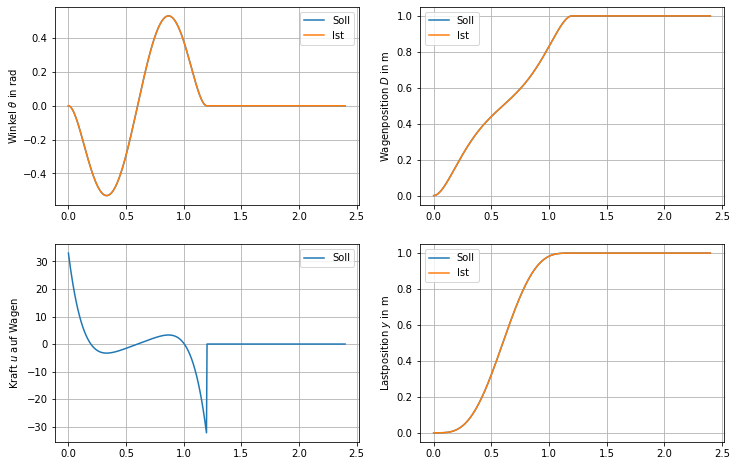

In [19]:
#Anfangsbedingungen
x0=np.zeros((4,))

#Simulation des linearen Systems
fkt_u=lambda t,x:fkt_u_ff(t)
sys=lambda t,x:sysgantry_lin(t,x,params,fkt_u)
res = solve_ivp(sys, #zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
y=x[0,:]*params.l+x[2,:]
plot_results(t,(fkt_y_ff(t),y),(fkt_theta_ff(t),x[0]),(fkt_D_ff(t),x[2]),(fkt_u_ff(t),))


Nun wird auch das nichtlineare Modell simuliert. Natürlich kann es nun zu Unterschieden zwischen Simulation und Planung kommen, da die Trajektorienplanung auf der Basis des linearen Modells erfolgte.

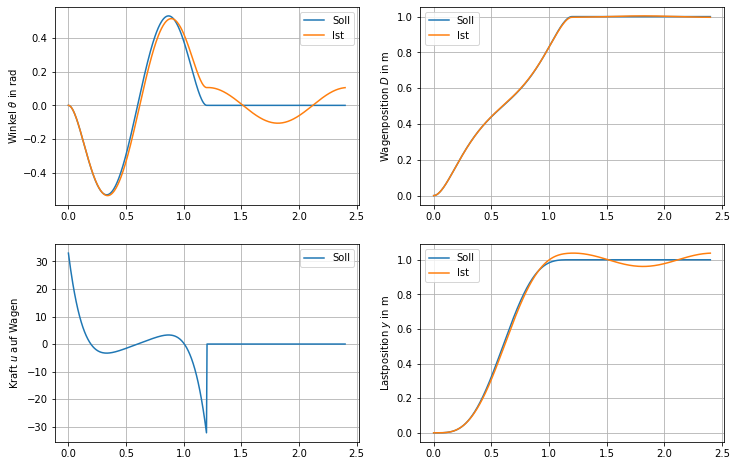

In [20]:
#Anfangsbedingungen
x0=np.zeros((4,))

#Simulation des nicht-linearen Systems
fkt_u=lambda t,x:fkt_u_ff(t)
sys=lambda t,x:sysgantry(t,x,params,fkt_u)
res = solve_ivp(sys,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
y=x[0,:]*params.l+x[2,:]
plot_results(t,(fkt_y_ff(t),y),(fkt_theta_ff(t),x[0]),(fkt_D_ff(t),x[2]),(fkt_u_ff(t),))



## 2.1 Reglerentwurf mittels Eigenwertvorgabe 
Für den Reglerentwurf stehen verschiedene Methoden zur Verfügung. Sicherlich ist ein hierarchischer Ansatz mit zwei kaskadierten Reglern für Lastposition und Wagenposition aus Anwendungssicht vor allem dann sinnvoll, wenn der Wagen einer unbekannten und hier nicht im Modell berücksichtigten Reibung unterliegt. 

Aus didaktischen Gründen soll hier allerdings eine vollständige Zustandsrückführung für das Gesamtmodell entworfen werden. Dazu werden nachfolgend zwei verschiedene Vefahren genutzt, Eigenwertvorgabe und der Entwurf nach einem  quadratischen Gütekriterium. 

Dazu werden zunächst noch einmal die Systemmatrizen der Zustandsdarstellung angegeben. 

In [22]:
#Matrixdarstellung für das zeitkontinuierliche Modell
M=params.M
m=params.m
g=params.g
l=params.l

A=np.array([[0,1,0,0],
            [-g*(m+M)/l/M,0,0,0],
            [0,0,0,1],
            [m*g/M,0,0,0]])
B=np.array([[0],
            [-1/l/M],
            [0],
            [1/M]])
D=np.array([[0]])
C=np.array([[l,0,1,0]])

Die Eigenwertvorgabe für das gegebene Modell soll mit der Ackermannformel erfolgen, dazu wird zunächst die Gleichung des flachen Ausgangs, bzw. die letzte Zeile der inversen Steuerbarkeitsmatrix benötigt.
Im speziellen Fall ist ein flacher Ausgang allerdings bereits bekannt, er entspricht der Lastposition und kann mit
Hilfe der Ausgabematrix $\boldsymbol{c}^T=(\ell,0,1,0)$ aus dem Zustand berechnet werden. Dies kann natürlich für den Reglerentwurf mittels Polvorgabe genutzt werden und hat den Vorteil, dass an keiner Stelle irgendwelche Matrizen invertiert werden müssen. 

Trotz des möglichen einfacheren Weges soll hier noch einmal der Weg über die Inverse Steuerbarkeitsmatrix beschritten werden.

In [23]:
#Ackermannformel für Eingrößensysteme
def acker_siso(A,B,eigs):
    #Dimension
    n=len(eigs)
    
    #Dimension der Matrizen prüfen
    assert(A.shape==(n,n))
    assert(len(B)==n)
    
    #Steuerbarkeitsmatrix berechnen S=(B,AB,...,A^{n-1} B)
    S=B
    for ii in range(n-1):
       S=np.hstack((S,A@S[:,-1:])) 
    
    
    #letzte Zeile der Inversen bestimmen
    Sinv=np.linalg.inv(S)
    q=Sinv[-1:,:]

    #Koeffizienten des Wunschpolynoms
    coeffs=np.poly(eigs)

    #letzter Koeffizient sollte 1 sein
    assert(coeffs[0]==1)
    
    #Reglerverstärkungen berechne k=coeffs[0]*q+coeffs[1]*q*A+...+coeffs[n-1]*q*A^{n-1}+q*A^n
    k=np.zeros((1,n))
    for ii in range(n+1):
       k += q*coeffs[n-ii] 
       q = q @ A
    
    return k


Um die Eigenwerte sinnvoll zu platzieren werden zunächst einmal die Eigenwerte des offenen Regelkreises bestimmt.
Die Eigenwerte des geschlossenen Kreises werden dann etwas verschoben.

In [35]:
#Eigenwerte des offenen Regelkreises
eigs=np.linalg.eigvals(A)
print(eigs)
#omega0 entspricht hier betragsmäßig größtem Eigenwert
omega0=np.abs(max(eigs))
#Dämpfungsmaß setzen
d=0.5

#Wunscheigenwerte des geschlossenen Regelkreises
eigs=omega0*np.array([-d,-d,-d+1j*np.sqrt(1-d**2),-d-1j*np.sqrt(1-d**2)])

#Ackermannformel auswerten
k=acker_siso(A,B,eigs)
print(k)

#oder funktion place_poles verwenden (funktioniert nur für paarweise verschiedene Eigenwerte)
#state_feedback=place_poles(A,B,eigs)
#print(state_feedback.gain_matrix)

#Regler definieren
def fkt_u_fb(t,x,fkt_u_ff,fkt_x_ff):
    xd=fkt_x_ff(t)
    u_fb=k@(x-xd)
    u=fkt_u_ff(t)-u_fb
    return u


[0.+0.j         0.+0.j         0.+5.19398691j 0.-5.19398691j]
[[-21.04245     -2.59699345  14.837625    14.283464  ]]


Wir simulieren noch einmal mit dem nicht-linearen Modell und einem Anfangsfehler im Winkel:

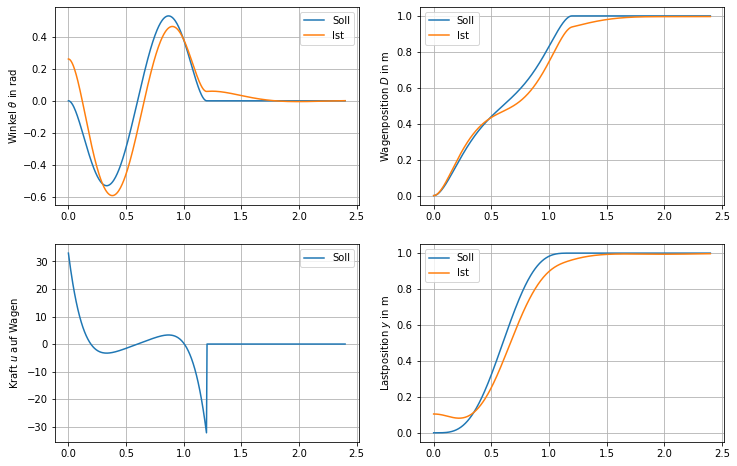

In [37]:
#Anfangsbedingungen
x0=np.zeros((4,))
x0[0]=15/180*np.pi

#Simulation des nicht-linearen Systems
fkt_u=lambda t,x:fkt_u_fb(t,x,fkt_u_ff,fkt_x_ff)
sys = lambda t,x:sysgantry(t,x,params,fkt_u)
res = solve_ivp(sys,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
y=x[0,:]*params.l+x[2,:]
plot_results(t,(fkt_y_ff(t),y),(fkt_theta_ff(t),x[0]),(fkt_D_ff(t),x[2]),(fkt_u_ff(t),))


# 3 Zeitdiskreter Entwurf
## 3.1 Zeitdiskretes Simulationsmodell
Das Zeitdiskrete Simulationsmodell ist im wesentlichen als Schleife aufgebaut. In jedem Abtastschritt wird zunächst der Eingang aktualisiert. Im Anschluss wird das System, mit diesem Wert für den Eingang, über eine Abtastperiode simuliert.

In [62]:
def simulate_discrete(sys,x0,fkt_u,Ta,Tsim):
    #nonlinear simulation
    t=np.array([])
    u=np.array([])
    x=np.zeros((len(x0),0))
    k=0
    while k*Ta<Tsim:
        uk=fkt_u(k,x0)
        asys=lambda t,x:sys(t,x,lambda t,x:uk)
        res=solve_ivp(asys,
                      [k*Ta,(k+1)*Ta],
                      x0,
                      t_eval=np.linspace(k*Ta,(k+1)*Ta,20),
                      atol=1e-9,
                      rtol=1e-6)
        t=np.hstack((t,res.t))
        x=np.hstack((x,res.y))
        u=np.hstack((u,uk*np.ones_like(res.t)))
        k+=1
        x0=x[:,-1]
    return t,x,u

Für alle nachfolgenden zeitdiskreten Schritte muss zunächst das Systemmodell mit der gewählten Abtastschrittweite $T_a$ diskretisiert werden.

Wir simulieren das zeitdiskrete Modell mit unserem Regler.

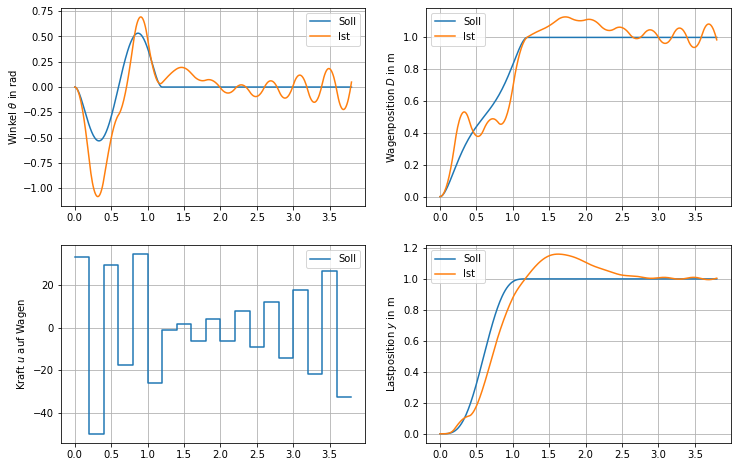

In [63]:
# Anfangs und Endwerte für Lastposition (bzw. Schlittenposition) 
traj = struct()
traj.y0 = 0
traj.yT = 1.0

#Übergangszeit
traj.T = 1.5

Ta=0.2

#Simulationszeit
Tsim=2*traj.T+4*Ta

#Initial state
x0=np.zeros((4,))

#Zeitdiskrete Simulation
sys=lambda t,x,fkt_u:sysgantry(t,x,params,fkt_u)

#fkt_u=lambda k,x:fkt_u_ff(k*Ta)
fkt_u=lambda k,x:fkt_u_fb(k*Ta,x,fkt_u_ff,fkt_x_ff)

t,x,u=simulate_discrete(sys,x0,fkt_u,Ta,Tsim)

#Ergebnisse Plotten
y=x[0,:]*params.l+x[2,:]
plot_results(t,(fkt_y_ff(t),y),(fkt_theta_ff(t),x[0]),(fkt_D_ff(t),x[2]),(u,))

## 3.2 Steuerungsentwurf

### 3.2.1. Flacher Ausgang des zeitdiskreten Modells

Der flache Ausgang des zeitdiskreten Modell stimmt nicht mit dem flachen Ausgang des kontinuierlichen Modells überein. Er wird über die Transformation auf Regelungsnormalform bestimmt.

In [72]:
Ta=0.2
Ad, Bd, Cd, Dd, Ta = cont2discrete (( A ,B , C , D ) , Ta )

#Steuerbarkeitsmatrix
Sd=np.hstack((Bd,Ad@Bd,Ad@Ad@Bd,Ad@Ad@Ad@Bd))
Sd_inv=np.linalg.inv(Sd)

#Flacher Ausgang durch letzte Zeile der inversen Steuerbarkeitsmatrix definiert
q0=Sd_inv[-1,:]

#Transformationsmatrix auf Regelungsnormalform
Qd=np.vstack((q0,q0@Ad,q0@Ad@Ad,q0@Ad@Ad@Ad))
Qd_inv=np.linalg.inv(Qd)

#Systemmatrix in Regelungsnormalform
Ad_rnf=Qd@Ad@Qd_inv
Ad_rnf[np.abs(Ad_rnf)<1e-14]=0
#Parametrierung von y durch flachen Ausgang
Cd_rnf=Cd@Qd_inv

### 3.2.2. Trajektorienplanung und Simulation im offenen Kreis

In [73]:
# Plane Trajektorien
def kran_planung_discrete(modell,traj,Ad_rnf,Cd_rnf,Qd_inv,Ta):
    scale=np.sum(Cd_rnf)
    # Trajektorie des flachen Ausgangs
    def fkt_eta(k,n):
        tau = (k-4+n)*Ta  / (traj.T-4*Ta)
        return (traj.y0 + (traj.yT - traj.y0) * fkt_phi(tau,0))/scale
    
    #Zustand in Regelungsnormalform
    fkt_xrnf=lambda k:np.vstack((fkt_eta(k,0),fkt_eta(k,1),fkt_eta(k,2),fkt_eta(k,3)))
    
    #Lastposition
    fkt_y=lambda k:(Cd_rnf@fkt_xrnf(k))[0,:]
    
    #Zustand
    fkt_x=lambda k:Qd_inv@fkt_xrnf(k)
    
    #Kraft
    fkt_u=lambda k:(-Ad_rnf[3,:]@fkt_xrnf(np.floor(k))+fkt_eta(np.floor(k),4))
    
    #Winkel
    fkt_theta=lambda k:(Qd_inv[0:1,:]@fkt_xrnf(k))[0,:]
    
    #Wagenposition
    fkt_D=lambda k:(Qd_inv[2:3,:]@fkt_xrnf(k))[0,:]

    return fkt_y, fkt_D, fkt_u, fkt_theta, fkt_x

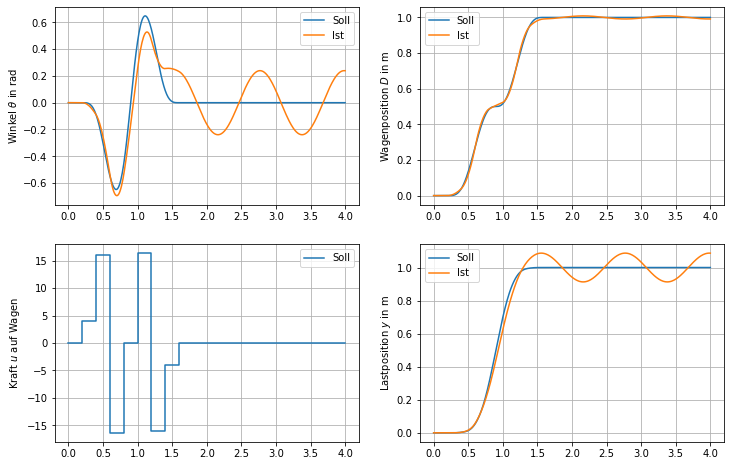

In [77]:
# Anfangs und Endwerte für Lastposition (bzw. Schlittenposition) 
traj = struct()
traj.y0 = 0
traj.yT = 1.0

#Übergangszeit
traj.T = 1.6

#berechne diskrete Solltrajektorien 
fkt_yd_ff, fkt_Dd_ff, fkt_ud_ff, fkt_thetad_ff,fkt_xd_ff = kran_planung_discrete(params,traj,Ad_rnf,Cd_rnf,Qd_inv,Ta)

#Simulationszeit
Tsim=2*traj.T+4*Ta

#Initial state
x0=np.zeros((4,))

#Zeitdiskrete Simulation
fkt_u=lambda k,x:fkt_ud_ff(k)
sys=lambda t,x,fkt_u:sysgantry(t,x,params,fkt_u)
t,x,u=simulate_discrete(sys,x0,fkt_u,Ta,Tsim)

#Ergebnisse Plotten
y=x[0,:]*params.l+x[2,:]
plot_results(t,(fkt_yd_ff(t/Ta),y),(fkt_thetad_ff(t/Ta),x[0]),(fkt_Dd_ff(t/Ta),x[2]),(u,))

## 3.3. Reglerentwurf

In [78]:
##Polplatzierung
#Wunschpolynom geschlossener Regelkreis
eigsd=np.exp(eigs*Ta)

#Ackermannformel auswerten
kd=acker_siso(Ad,Bd,eigsd)

#Regler definieren
def fkt_ud_fb(td,x,fkt_ud_ff,fkt_xd_ff):
    xd=fkt_xd_ff(td)
    if len(np.shape(td))==0:
        xd=xd[:,0]
    u_fb=kd@(x-xd)
    u=fkt_ud_ff(td)-u_fb
    return u

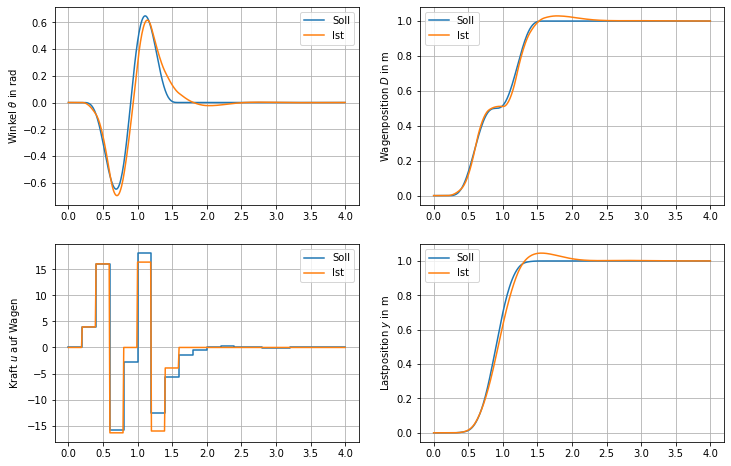

In [79]:
#Anfangsbedingungen
x0=np.zeros((4,))
#x0[0]=15/180*np.pi

#Simulation des nicht-linearen Systems
sys=lambda t,x,fkt_u:sysgantry(t,x,params,fkt_u)
fkt_u=lambda td,x:fkt_ud_fb(td,x,fkt_ud_ff,fkt_xd_ff)
t,x,u=simulate_discrete(sys,x0,fkt_u,Ta,Tsim)

#Ergebnisse Plotten
y=x[0,:]*params.l+x[2,:]
theta=fkt_thetad_ff(t/Ta)
plot_results(t,(fkt_yd_ff(t/Ta),y),(fkt_thetad_ff(t/Ta),x[0]),(fkt_Dd_ff(t/Ta),x[2]),(u,fkt_ud_ff(t/Ta)))
